In [ ]:
import numpy as np 
import torch
import pickle as pkl 
import torch
from torch.nn import functional as F
from reco import RecoSystem
import matplotlib.pyplot as plt
# reload notebook autoreload extension
from plotparams import init_plotting

init_plotting()
%load_ext autoreload
%autoreload 2

In [2]:
with open('./30embds_text_llama_flava.pkl', 'rb') as f:
    modelembeddings = pkl.load(f)
sources = list(modelembeddings.keys())
print(sources)

['bert-base-uncased', 'distilbert-base-uncased', 'xlnet-base-cased', 'xlm-roberta-base', 'flava', 'meta-llama-3-8B']


In [3]:
# preference data of users
men_preferences = np.load('./men_profile_preferences.npy')
women_preferences = np.load('./women_profile_preferences.npy')

In [5]:
splits = np.arange(1, 10)*0.1
epochs = 10

splitdata = {}
for s in sources:
    #initialize split data
    splitdata[s] = {}

for split in splits:
    expdata = {}
    for s in sources:
        man_embeddings = modelembeddings[s]['Man']
        woman_embeddings = modelembeddings[s]['Woman']
        r_man = RecoSystem(embeddings=man_embeddings, preferences=men_preferences)
        r_woman = RecoSystem(embeddings=woman_embeddings, preferences=women_preferences)
        man_data = r_man.train(split=split, epochs=epochs)
        woman_data = r_woman.train(split=split, epochs=epochs)
        expdata[s] = {"Man":man_data, "Woman":woman_data}
        splitdata[s][split] = expdata[s]



with open(f'exp_splits_{epochs}_text_llama_flava_train.pkl', 'wb') as f:
    pkl.dump(splitdata, f)

C:\Users\Pranav Kumar Kota\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Pranav Kumar Kota\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


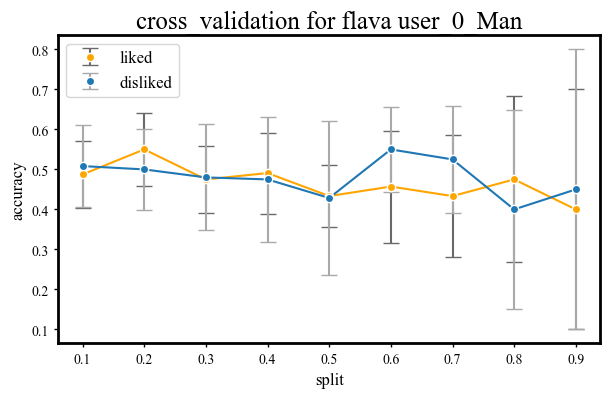

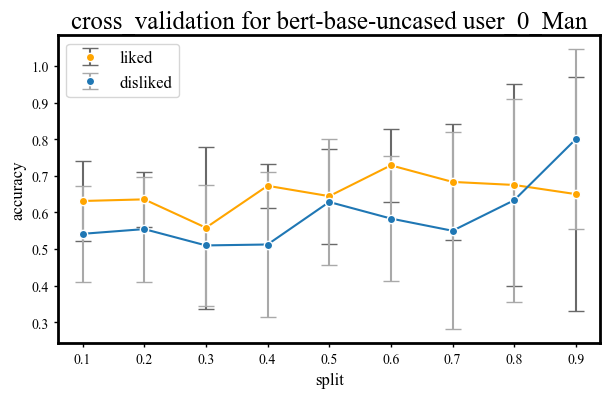

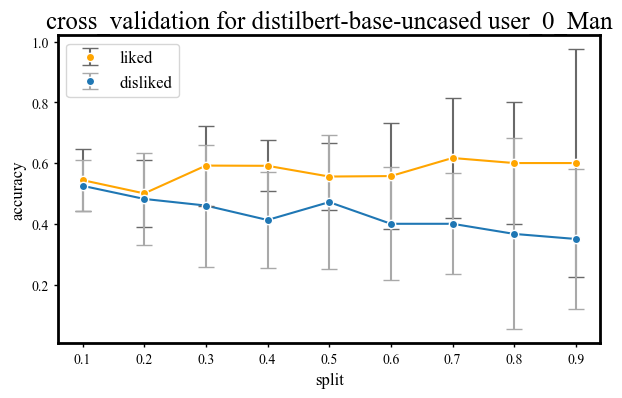

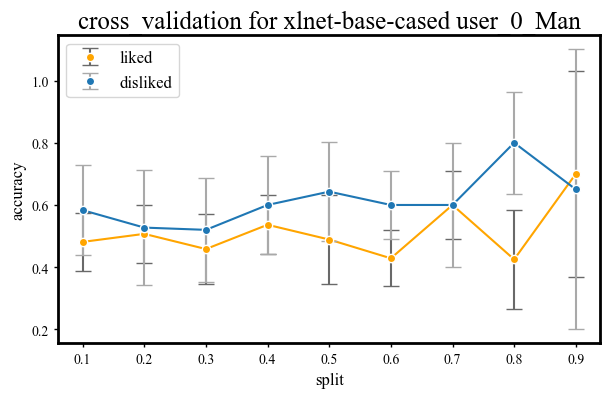

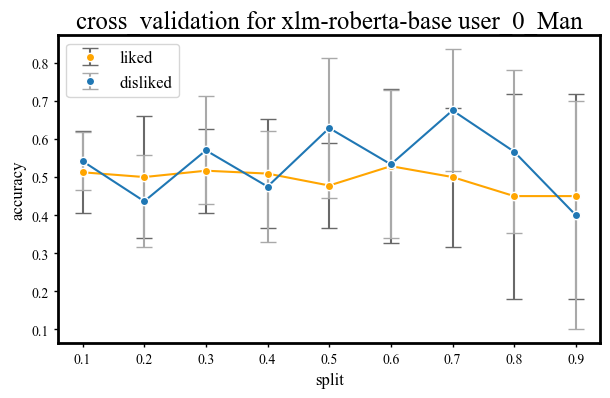

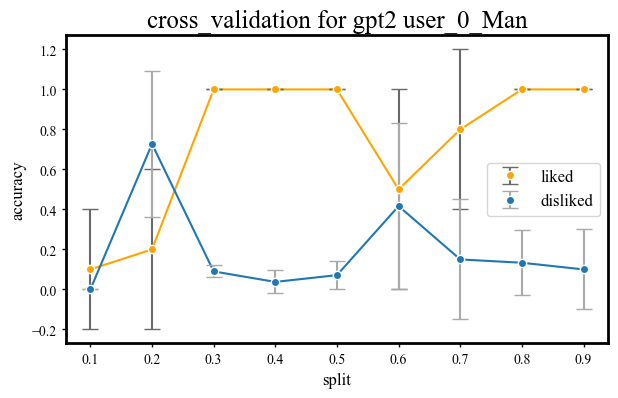

In [72]:
def plot(splitdata, usridx, model, gender='Man', save=False):
    liked_acc_split = []
    disliked_acc_split = []
    liked_var_split = []
    disliked_var_split = []
    modeldata = splitdata[model]
    splits = list(modeldata.keys())
    for split in splits:
        # print(split)
        usrdata = (modeldata[split][gender][usridx])
        liked_acc_split.append(usrdata["liked_acc"])
        disliked_acc_split.append(usrdata["disliked_acc"])
        liked_var_split.append(usrdata["liked_var"])
        disliked_var_split.append(usrdata["disliked_var"])

    lv = np.sqrt(liked_var_split)
    dv = np.sqrt(disliked_var_split)
    plt.plot(splits, liked_acc_split, color='orange')
    plt.plot(splits, disliked_acc_split, color='#1f77b4')
    plt.errorbar(splits, liked_acc_split, yerr=lv, fmt='o', capsize=6, ecolor='dimgray',
                 mfc='orange' ,mec='white', label='liked')
    plt.errorbar(splits, disliked_acc_split, yerr=dv, fmt='o', capsize=6, ecolor='darkgray',
                 mfc='#1f77b4',mec='white', label='disliked')	

    # plt.legend(["liked", 'disliked'])
    plt.legend()
    plt.xlabel("split")
    plt.ylabel("accuracy")
    title = f"cross_validation for {model} user_{usridx}_{gender}"
    plt.title(title)
    if(save):
        plt.savefig(title+'.pdf')
    plt.show()
    
for s in sources:
    plot(splitdata, 0, s, save=False, gender='Man')

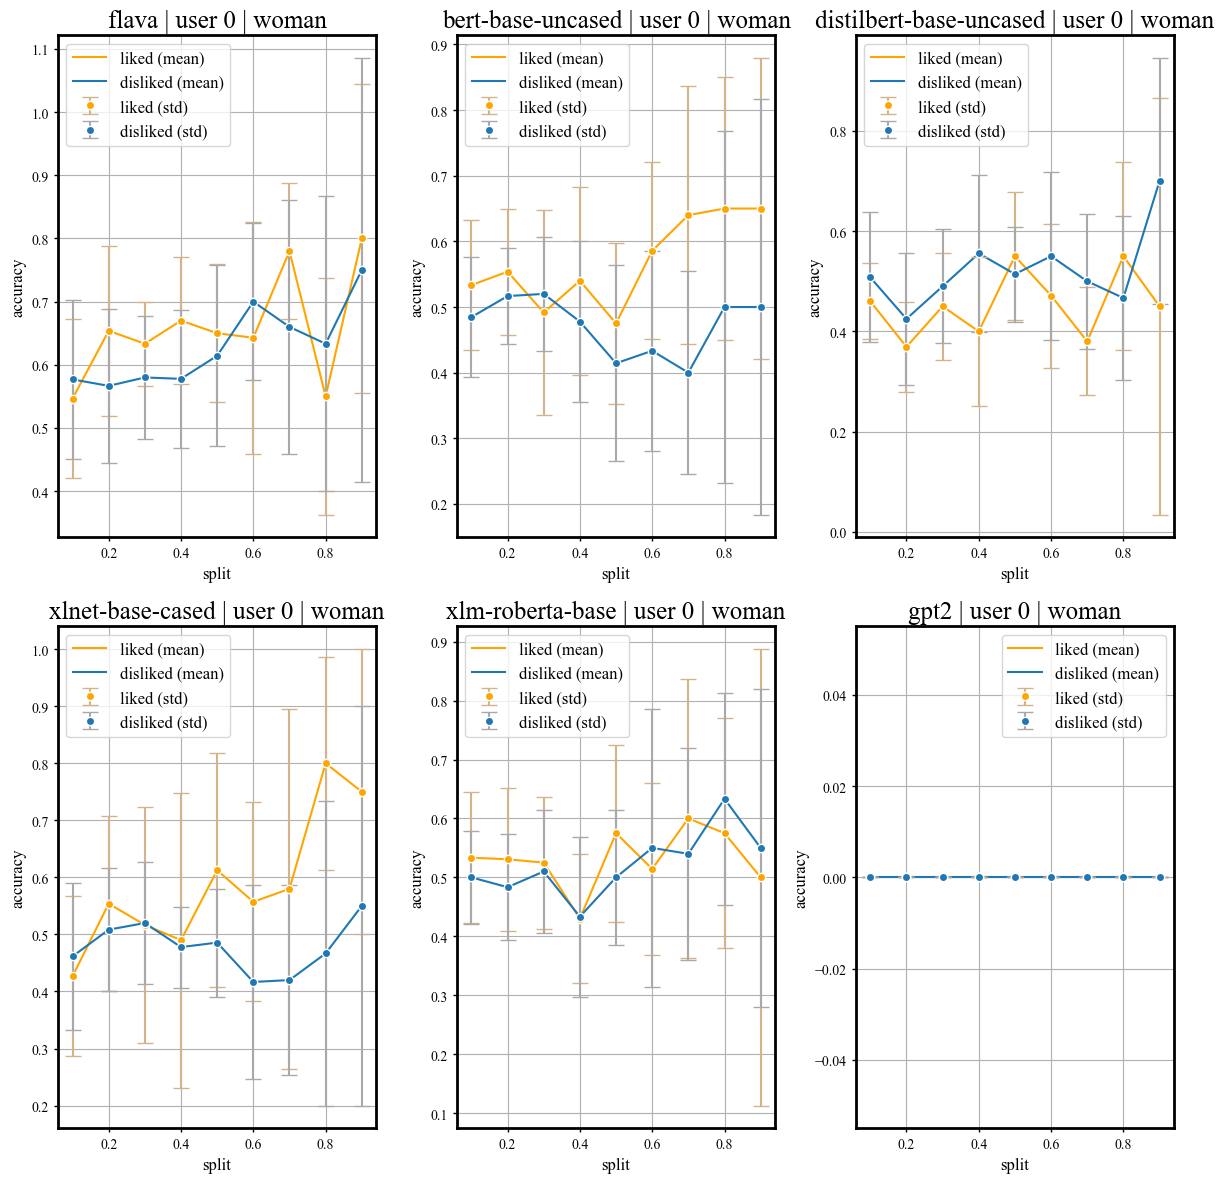

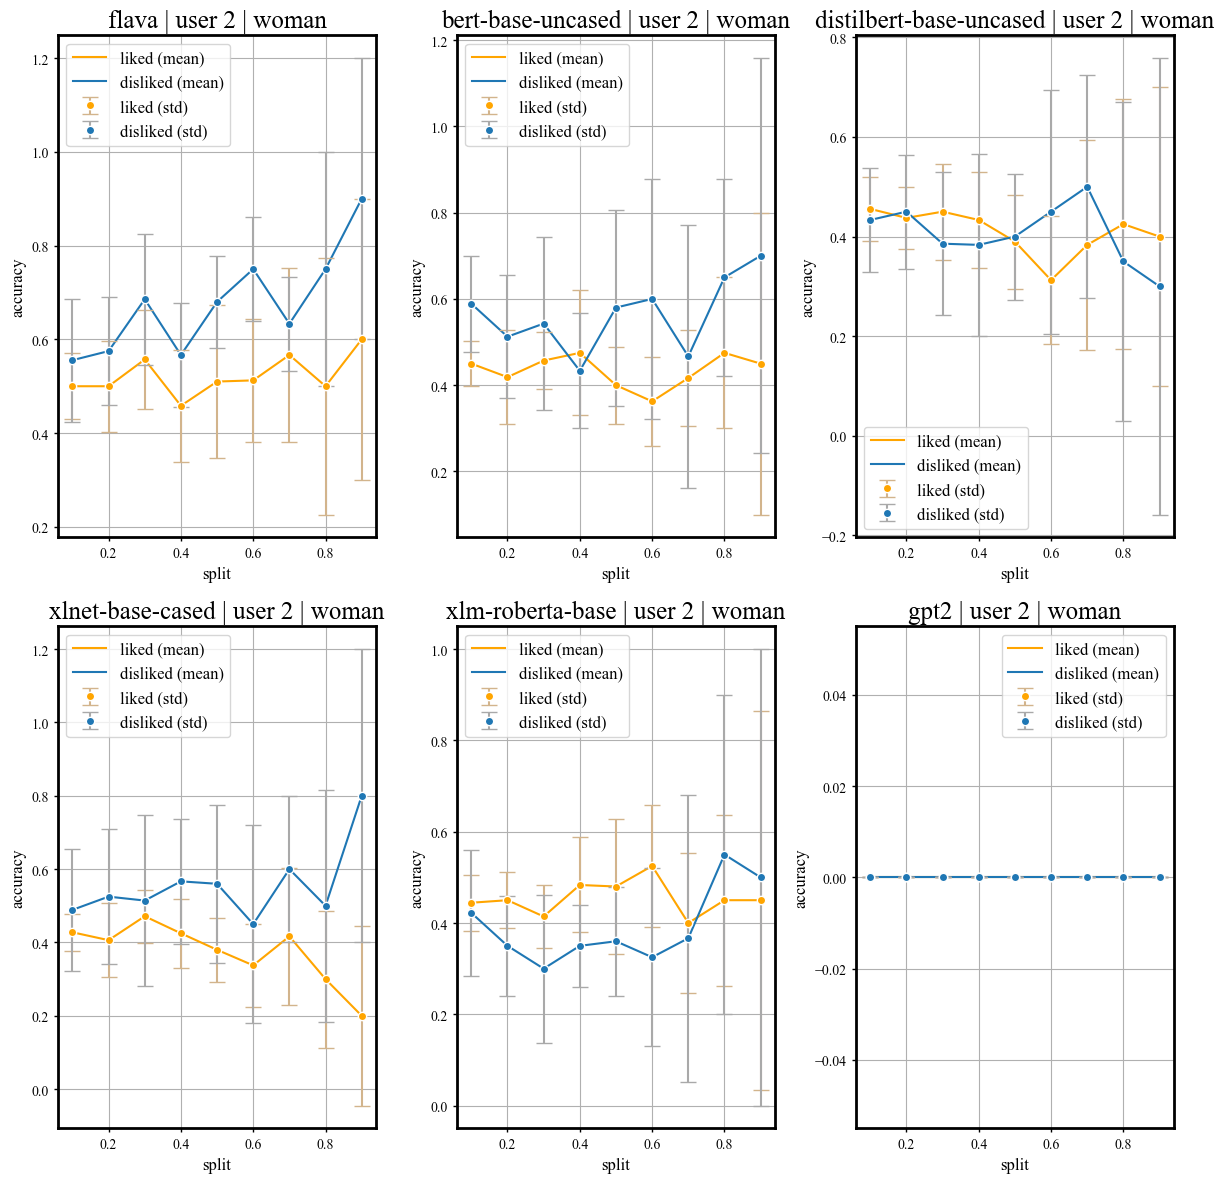

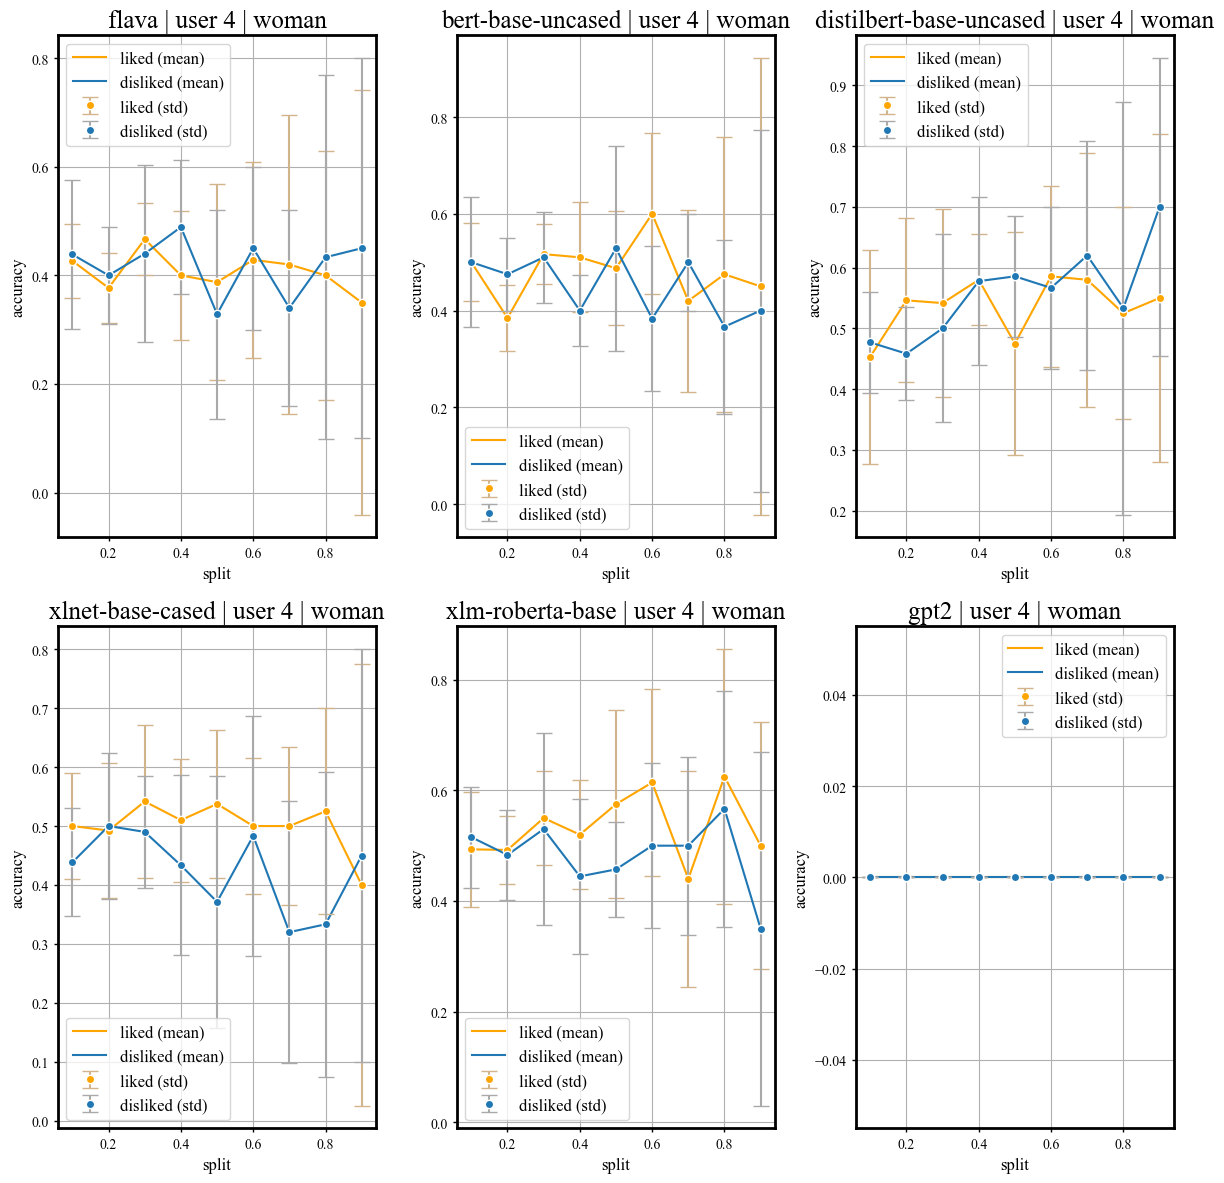

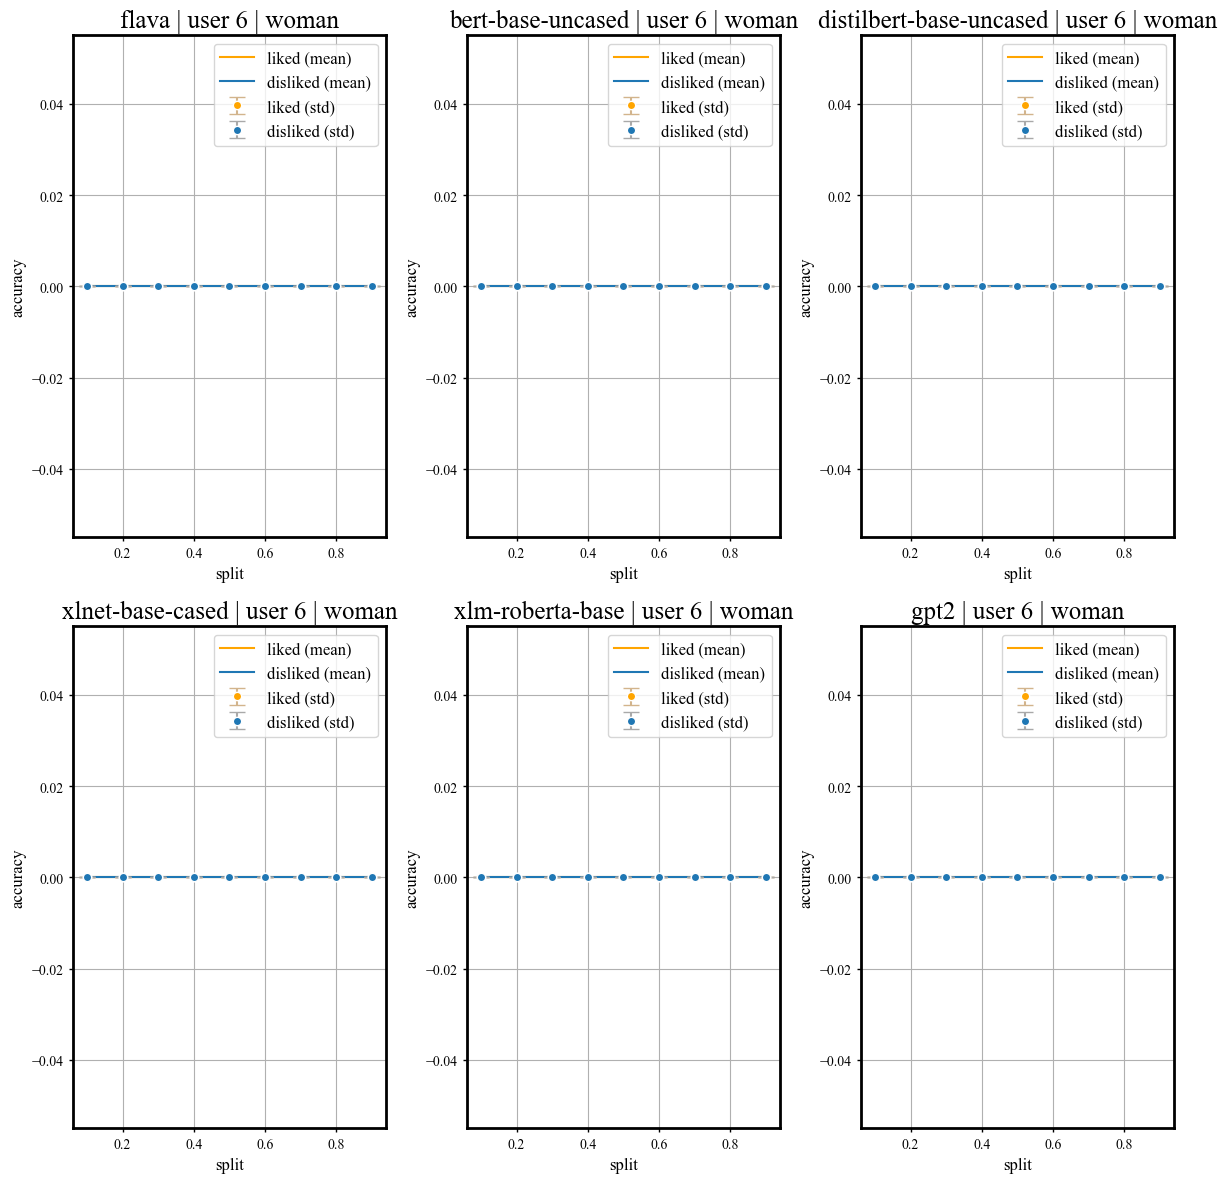

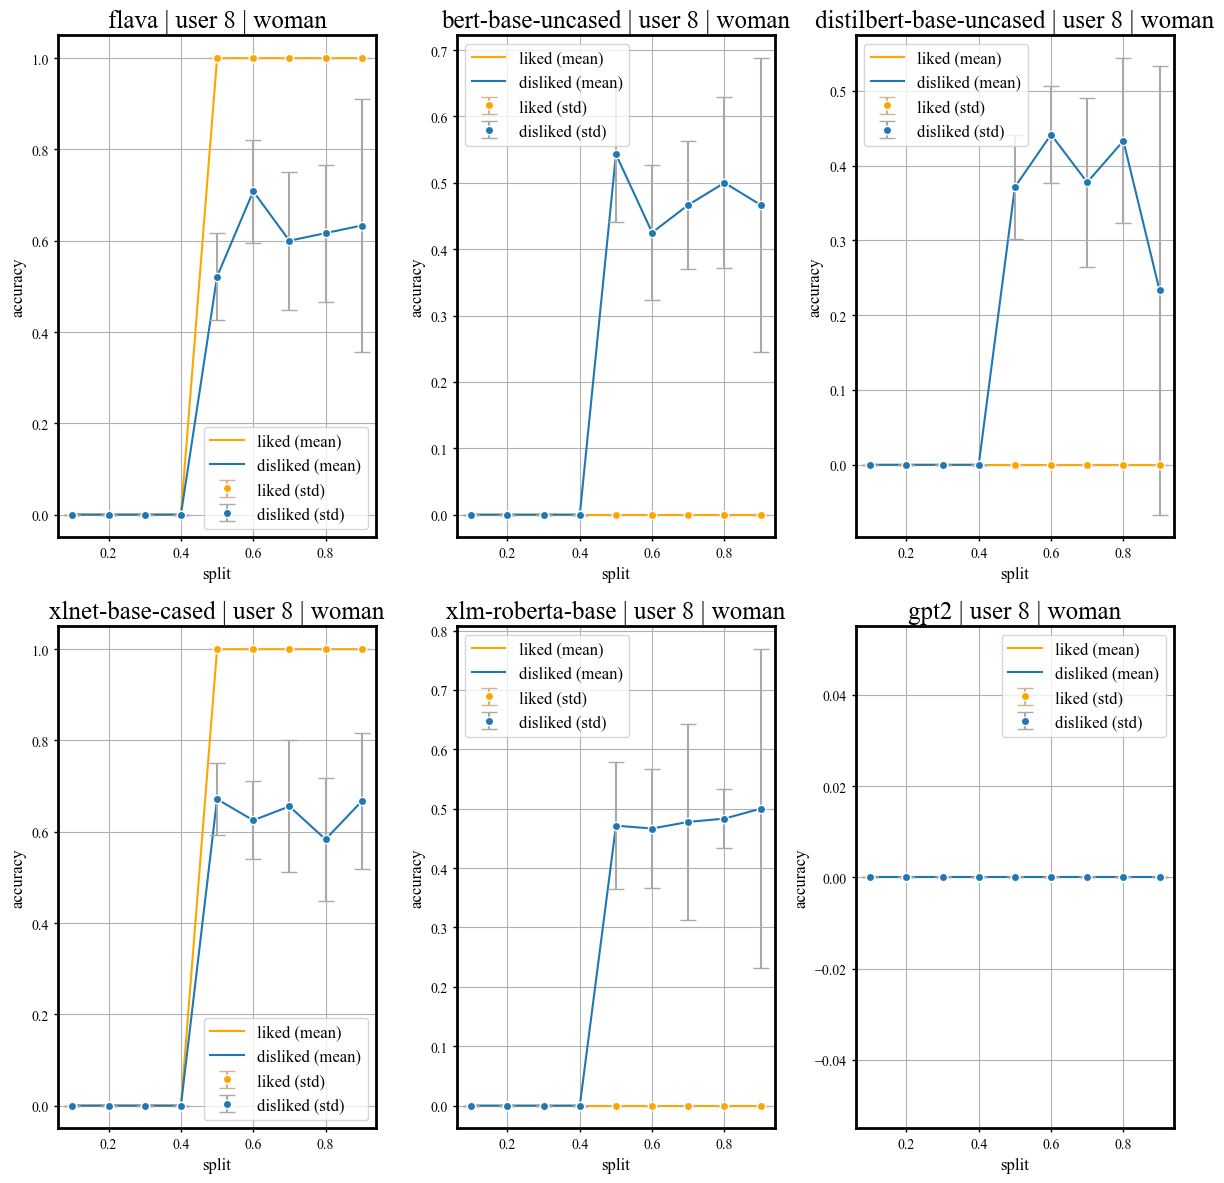

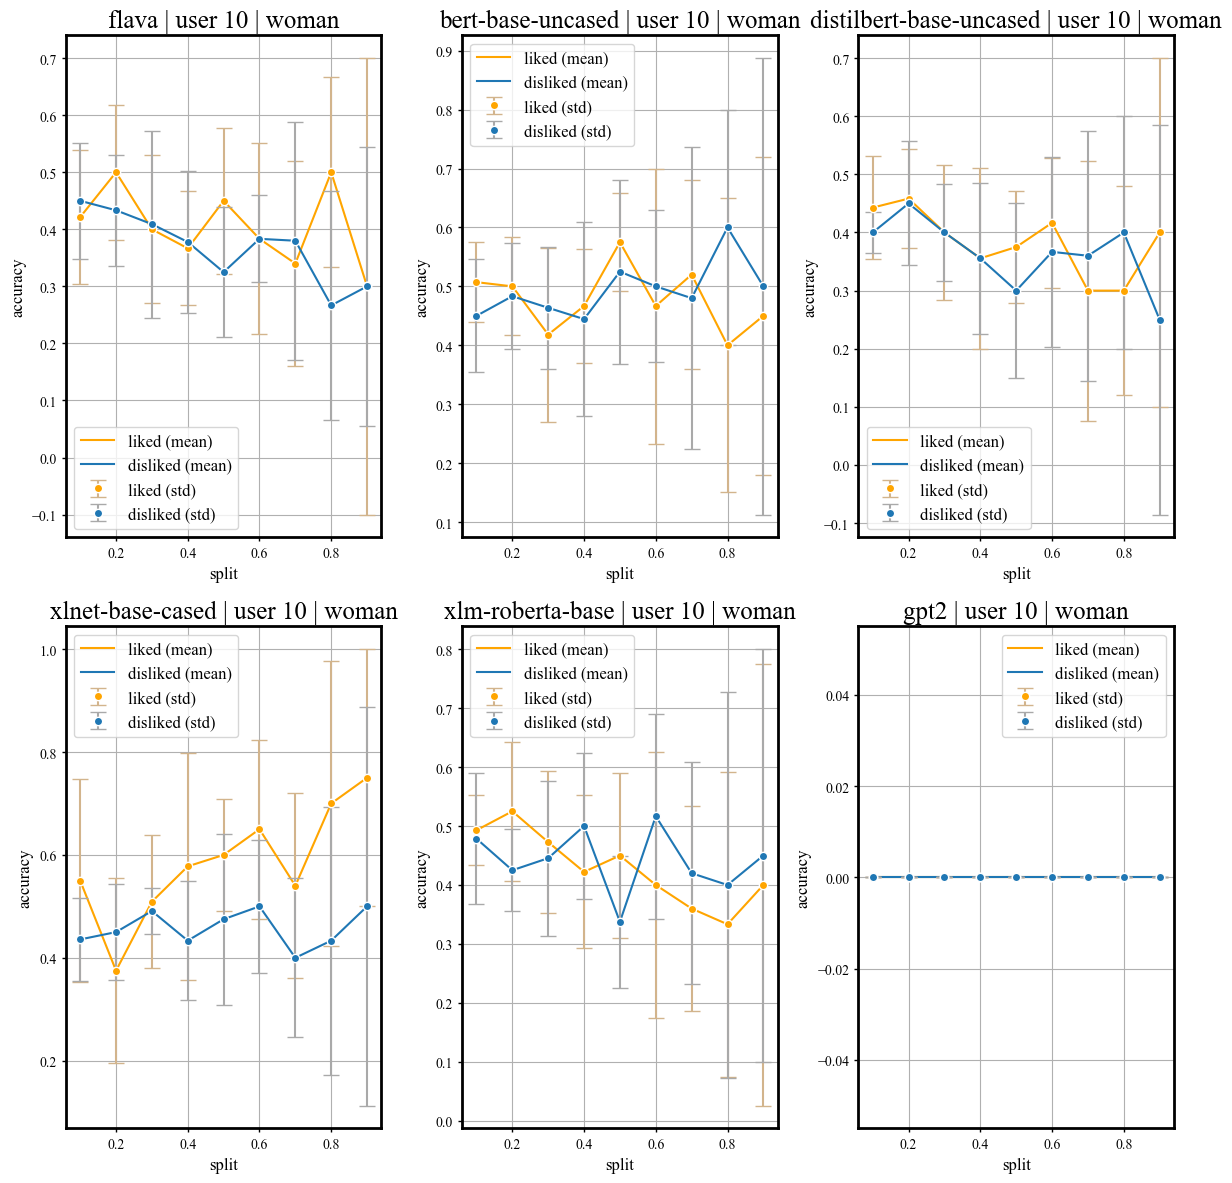

In [78]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_models(splitdata, usridx, models, gender='Man', save=False):
    """
    Plots accuracy and error bars for all specified models in subplots.

    Parameters:
        splitdata: dict - The data structure containing split information.
        usridx: int - The user index to extract data for.
        models: list - List of model names to plot.
        gender: str - The gender of the user.
        save: bool - Whether to save the plot to a file.
    """
    # Determine the layout of subplots
    n_models = len(models)
    n_cols = 3  # Define how many subplots per row
    n_rows = (n_models + n_cols - 1) // n_cols  # Calculate rows based on number of models

    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6 * n_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes to iterate easily

    for idx, model in enumerate(models):
        liked_acc_split = []
        disliked_acc_split = []
        liked_var_split = []
        disliked_var_split = []

        modeldata = splitdata[model]
        splits = list(modeldata.keys())

        for split in splits:
            usrdata = (modeldata[split][gender][usridx])
            liked_acc_split.append(usrdata["liked_acc"])
            disliked_acc_split.append(usrdata["disliked_acc"])
            liked_var_split.append(usrdata["liked_var"])
            disliked_var_split.append(usrdata["disliked_var"])

        lv = np.sqrt(liked_var_split)
        dv = np.sqrt(disliked_var_split)
        # lv = (liked_var_split)
        # dv = (disliked_var_split)

        # Plot on the corresponding subplot
        ax = axes[idx]
        ax.plot(splits, liked_acc_split, color='orange', label='liked (mean)')
        ax.plot(splits, disliked_acc_split, color='#1f77b4', label='disliked (mean)')
        ax.errorbar(splits, liked_acc_split, yerr=lv, fmt='o', capsize=6, ecolor='#D2B48C',
                    mfc='orange', mec='white', label='liked (std)')
        ax.errorbar(splits, disliked_acc_split, yerr=dv, fmt='o', capsize=6, ecolor='darkgray',
                    mfc='#1f77b4', mec='white', label='disliked (std)')

        ax.set_xlabel("split")
        ax.set_ylabel("accuracy")
        ax.set_title(f"{model} | user {usridx} | {str(gender).lower()}")
        ax.legend()
        ax.grid(True)

    # Remove unused axes (if models < n_rows * n_cols)
    for ax in axes[len(models):]:
        ax.axis('off')

    # Adjust layout and optionally save
    plt.tight_layout()
    if save:
        plt.savefig(f"cross_validation_user_{usridx}_{gender}.pdf")
    plt.show()

for u in [0, 2, 4, 6, 8, 10]:
    plot_all_models(splitdata, models=sources, usridx=u, gender='Woman', save=True)